# Intro
The following analysis confirms that our Bayesian Optimisation Algorithm by reusing the empirical Mevalonate Pathway data from:


The source of the data [data\mevalonate_pathway\ao2c00483_si_002.xlsx](data\mevalonate_pathway\ao2c00483_si_002.xlsx) is

``` text
@article{Shin2022,
  title = {Transcriptional Tuning of Mevalonate Pathway Enzymes to Identify the Impact on Limonene Production in Escherichia coli},
  author = {Shin, Jonghyeon and South, Eric J. and Dunlop, Mary J.},
  journal = {ACS Omega},
  year = {2022},
  volume = {7},
  number = {22},
  pages = {18331--18338},
  publisher = {American Chemical Society},
  doi = {10.1021/acsomega.2c00483},
  url = {https://doi.org/10.1021/acsomega.2c00483}
}
``` 

In [ ]:
import pandas as pd
from src.helpers import MeshGridSlicePlotter
from src.helpers import empirical_helper
import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.gp_and_acq_f.custom_gp_and_acq_f import MaternKernelSGP
from src import ax_helper as ax_helper
from ax import RangeParameterConfig
from botorch.models import SingleTaskGP
from IPython.display import Image, display
from src.helpers import MeshGridSlicePlotter as mg_mod
import numpy as np
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import SplineTransformer
import plotly.express as px
import pickle as pkl
import pickle

y_matrix = pd.read_excel(
    "data/mevalonate_pathway/ao2c00483_si_002.xlsx", sheet_name="Table S2"
)
y_matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Ara                 648 non-null    float64
 1   Cho                 648 non-null    float64
 2   Cuma                648 non-null    float64
 3   IPTG                672 non-null    int64  
 4   Limonene (mg/L)     564 non-null    float64
 5   Normalization       564 non-null    float64
 6   Average             308 non-null    float64
 7   Error               224 non-null    float64
 8   Unnamed: 8          0 non-null      float64
 9   Average.1           82 non-null     float64
 10  Normalized Average  82 non-null     float64
dtypes: float64(10), int64(1)
memory usage: 57.9 KB


There are 672 unique observations, all features are numerically encoded - this situation is quite close top optimal for bayesian optimisation.

In [2]:
y_matrix.drop(columns=["Unnamed: 8"], inplace=True)

display(y_matrix.head(5))
display(y_matrix.iloc[100:110, :])
display(y_matrix.tail(5))

,Ara,Cho,Cuma,IPTG,Limonene (mg/L),Normalization,Average,Error,Average.1,Normalized Average
0,NaN,NaN,NaN,100,44.663564,0.963833,1.0,0.051148,75.536426,1.0
1,NaN,NaN,NaN,100,48.015464,1.036167,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,100,49.443499,1.137024,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,100,37.526531,0.862976,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,100,53.564586,1.301208,1.0,0.425972,NaN,NaN


,Ara,Cho,Cuma,IPTG,Limonene (mg/L),Normalization,Average,Error,Average.1,Normalized Average
100,2.0,200.0,2.0,25,86.297373,0.991499,0.991499,NaN,NaN,NaN
101,2.0,200.0,2.0,25,NaN,NaN,NaN,NaN,NaN,NaN
102,2.0,200.0,2.0,25,54.467532,0.433943,0.486863,0.074840,NaN,NaN
103,2.0,200.0,2.0,25,67.752249,0.539782,NaN,NaN,NaN,NaN
104,2.0,200.0,2.0,100,39.460593,0.851554,0.680256,0.242252,40.625515,0.546016
105,2.0,200.0,2.0,100,23.584890,0.508959,NaN,NaN,NaN,NaN
106,2.0,200.0,2.0,100,14.095775,0.396310,0.396310,NaN,NaN,NaN
107,2.0,200.0,2.0,100,NaN,NaN,NaN,NaN,NaN,NaN
108,2.0,200.0,2.0,100,54.473684,0.625866,0.625866,NaN,NaN,NaN
109,2.0,200.0,2.0,100,NaN,NaN,NaN,NaN,NaN,NaN


,Ara,Cho,Cuma,IPTG,Limonene (mg/L),Normalization,Average,Error,Average.1,Normalized Average
667,50.0,500.0,20.0,200,17.447853,0.374725,NaN,NaN,NaN,NaN
668,50.0,500.0,20.0,200,47.437939,0.343567,0.441837,0.138976,NaN,NaN
669,50.0,500.0,20.0,200,74.575385,0.540108,NaN,NaN,NaN,NaN
670,50.0,500.0,20.0,200,57.795455,0.428936,0.364586,0.091004,NaN,NaN
671,50.0,500.0,20.0,200,40.454361,0.300237,NaN,NaN,NaN,NaN


We can observe following situations:
* Nan Values encode 0 values of inducers (IPTG acts as a kinda baseline)
* Limomene is measured in (mg/ml) 
* There is some sort of normalisation going on for each measurement
* Afterwards the average and error are calculated from identical parameter conditions
* Some sort of normalisation is applied before calculating the average. Considering Limomene units, it's most likely normalising for OD or similar measure of overall bacterial growth.

In [3]:
parameters = ["Ara", "Cho", "Cuma", "IPTG"]
y_matrix.dropna(inplace=True, subset=parameters + ["Limonene (mg/L)"])
y_matrix["Limonene (mg/L)"] = y_matrix["Normalization"]
y_matrix.describe()

,Ara,Cho,Cuma,IPTG,Limonene (mg/L),Normalization,Average,Error,Average.1,Normalized Average
count,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,297.000000,216.000000,54.000000,54.000000
mean,20.666667,250.000000,10.100000,108.333333,0.540831,0.540831,0.547385,0.130898,37.221954,0.493123
std,21.016823,187.256335,8.173967,71.752512,0.335430,0.335430,0.316485,0.119374,16.986521,0.206196
min,2.000000,50.000000,2.000000,25.000000,0.017597,0.017597,0.058957,0.000302,9.046766,0.131578
25%,2.000000,50.000000,2.000000,25.000000,0.291972,0.291972,0.305330,0.031223,19.351871,0.281106
50%,10.000000,200.000000,5.000000,100.000000,0.491197,0.491197,0.514878,0.103608,40.487667,0.533857
75%,50.000000,500.000000,20.000000,200.000000,0.723293,0.723293,0.734656,0.200282,52.775696,0.669620
max,50.000000,500.000000,20.000000,200.000000,1.464294,1.464294,1.380739,0.608375,64.747251,0.783437


We can thus determine upper and lower bounds of inducers

In [4]:
param_bounds = {
    param: (float(y_matrix[param].min()), float(y_matrix[param].max())) for param in parameters
}
param_bounds

{'Ara': (2.0, 50.0),
 'Cho': (50.0, 500.0),
 'Cuma': (2.0, 20.0),
 'IPTG': (25.0, 200.0)}

In [5]:
paper_averages = y_matrix.dropna(subset=["Average"], inplace=False)
display(paper_averages.tail(4))
from math import log

print(f"There are {len(paper_averages)} unique averages")

,Ara,Cho,Cuma,IPTG,Limonene (mg/L),Normalization,Average,Error,Average.1,Normalized Average
664,50.0,500.0,20.0,200,1.172713,1.172713,0.835911,0.476310,42.128931,0.539303
666,50.0,500.0,20.0,200,0.655031,0.655031,0.514878,0.198206,NaN,NaN
668,50.0,500.0,20.0,200,0.343567,0.343567,0.441837,0.138976,NaN,NaN
670,50.0,500.0,20.0,200,0.428936,0.428936,0.364586,0.091004,NaN,NaN


There are 297 unique averages


In [6]:
y_matrix[parameters] = y_matrix[parameters].fillna(0)
dmeans = y_matrix.groupby(parameters).mean().tail(20)
print(f"There are {len(dmeans)} unique combinations of parameters")
print(
    f"Consequently, there are {log(len(dmeans), 4)} unique grid points, across each dimension."
)
print(f"global optimum of observed Average: {dmeans['Average'].max()} for")

best_empirical_obs = dmeans[dmeans["Average"] == dmeans["Average"].max()]
display(best_empirical_obs)

There are 20 unique combinations of parameters
Consequently, there are 2.1609640474436813 unique grid points, across each dimension.
global optimum of observed Average: 0.8162825946210317 for


,,,,Limonene (mg/L),Normalization,Average,Error,Average.1,Normalized Average
Ara,Cho,Cuma,IPTG,,,,,,
50.0,500.0,5.0,200,0.814477,0.814477,0.816283,0.20091,NaN,NaN


In [7]:
unique_combinations = y_matrix[parameters].drop_duplicates(ignore_index=True)
print(f"Number of unique parameter combinations: {len(unique_combinations)}")
display(unique_combinations)

Number of unique parameter combinations: 81


,Ara,Cho,Cuma,IPTG
0,2.0,50.0,2.0,25
1,2.0,50.0,2.0,100
2,2.0,50.0,2.0,200
3,2.0,50.0,5.0,25
4,2.0,50.0,5.0,100
...,...,...,...,...
76,50.0,500.0,5.0,100
77,50.0,500.0,5.0,200
78,50.0,500.0,20.0,25
79,50.0,500.0,20.0,100


* The paper calculates the first average from fewer groups, but then normalizes it to account for daily performance. We ignore this and treat data point as separate to get a more-representative situation of the model acting on raw, unfiltered data.

Due to the small number of unique parameter combinations(20), we will have to fit a smoothed shape throughout the grid in order to produce meaningful observation.

In [8]:
def signal_to_noise_from_paper_averages(
    df,
    value_col="Average",
    group_cols=["Ara", "Cho", "Cuma", "IPTG"],
    error_col="Error",
):
    group_means = df.groupby(group_cols)[value_col].mean()
    signal_var = group_means.var(ddof=1)
    if error_col in df.columns:
        # Use squared error as variance estimate
        group_errors = df.groupby(group_cols)[error_col].mean()
        noise_var = (group_errors**2).mean()

    return signal_var / noise_var


# Example usage:
snr_paper = signal_to_noise_from_paper_averages(paper_averages)
print(f"Signal-to-noise ratio from paper averages: {snr_paper:.2f}")
print(f"Which is {snr_paper:.2%}")
print(f"or that noise is equivalent to {1/snr_paper:.2%} of the variance of the signal")

Signal-to-noise ratio from paper averages: 2.41
Which is 241.06%
or that noise is equivalent to 41.48% of the variance of the signal


The data is extremely, noise, trying to overfit might be detrimental.

### Production of meshgrid

In [9]:
import numpy as np

param_ranges = {
    param: np.linspace(y_matrix[param].min(), y_matrix[param].max(), 20) for param in parameters
}

mesh = np.meshgrid(*param_ranges.values(), indexing="ij")

mesh_grid = pd.DataFrame({param: mesh[i].ravel() for i, param in enumerate(parameters)})

response_mesh_grid = mesh_grid.copy()


display(response_mesh_grid.tail())
print(f"Meshgrid shape: {response_mesh_grid.shape}")
[parameters]
optimum_coords = best_empirical_obs.reset_index()[parameters]
print("Optimum coordinates of the mesh grid:", optimum_coords)
display(pd.DataFrame(optimum_coords, index=[0]))

,Ara,Cho,Cuma,IPTG
159995,50.0,500.0,20.0,163.157895
159996,50.0,500.0,20.0,172.368421
159997,50.0,500.0,20.0,181.578947
159998,50.0,500.0,20.0,190.789474
159999,50.0,500.0,20.0,200.000000


Meshgrid shape: (160000, 4)
Optimum coordinates of the mesh grid:     Ara    Cho  Cuma  IPTG
0  50.0  500.0   5.0   200


,Ara,Cho,Cuma,IPTG
0,50.0,500.0,5.0,200


We first use custom parameter for scaling the bounds to 0,1 this is strictly enforced, due to how our target gaussian process behaves.

In [10]:
fit_data = y_matrix.dropna(subset=["Limonene (mg/L)"])

X_resp = fit_data[parameters]
y_resp = fit_data["Limonene (mg/L)"]

from sklearn.preprocessing import MinMaxScaler, Normalizer
from src.helpers.empirical_helper import RFKNN

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import numpy as np

# Define log transform (handle zeros safely)
log_transformer = FunctionTransformer(lambda x: np.log1p(x), validate=False)

def get_RfKnn_pipe():

    return Pipeline([
    ("normalizer", Normalizer()),
    ("0 to 1", MinMaxScaler()),
    ("rf_smooth", RFKNN(rf_params=dict(n_estimators=200, min_samples_leaf=7), n_neighbors=30)),])
signal_pipeline = get_RfKnn_pipe()

signal_pipeline

,steps,"[('normalizer', ...), ('0 to 1', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,norm,'l2'
,copy,True
,feature_range,"(0, ...)"
,copy,True
,clip,False
,rf_params,"{'min_samples_leaf': 7, 'n_estimators': 200}"
,n_neighbors,30


We then fit the limonene concentrations to construct the meshgrid later used for BO.

In [11]:
signal_pipeline.fit(X_resp.to_numpy(), y_resp.to_numpy().ravel())
response_mesh_grid["pred_response"] = signal_pipeline.predict(
    response_mesh_grid[parameters]
)

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.11\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning:

X has feature names, but Normalizer was fitted without feature names



### Accuracy of Meshgrid

<Axes: xlabel='pred_response', ylabel='Density'>

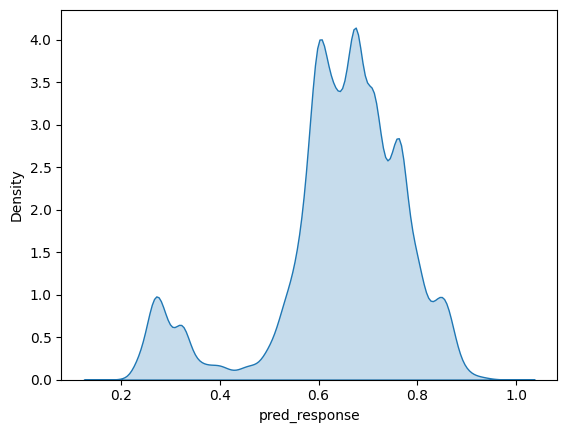

In [12]:
scaling_factor = response_mesh_grid["pred_response"].max()
response_mesh_grid["pred_response"] = (
    response_mesh_grid["pred_response"] / response_mesh_grid["pred_response"].max()
)
sns.kdeplot(response_mesh_grid["pred_response"], fill=True)

In [32]:
quantiles = {q/100:response_mesh_grid["pred_response"].quantile(q/100) for q in range(100)}

with open("data\mevalonate_pathway\quantiles.pkl", 'wb') as file:
    pickle.dump(quantiles, file)

quantiles

{0.0: np.float64(0.16248311758948283),
 0.01: np.float64(0.2547874468499105),
 0.02: np.float64(0.26445264030501575),
 0.03: np.float64(0.27353459087734766),
 0.04: np.float64(0.28263852728405314),
 0.05: np.float64(0.2945389215346857),
 0.06: np.float64(0.3152329416779814),
 0.07: np.float64(0.32711994571690406),
 0.08: np.float64(0.3502710003481635),
 0.09: np.float64(0.404352083994412),
 0.1: np.float64(0.47642774545228206),
 0.11: np.float64(0.5083360546458258),
 0.12: np.float64(0.5248909405992099),
 0.13: np.float64(0.5348861093834817),
 0.14: np.float64(0.5443324336904987),
 0.15: np.float64(0.5527347628831689),
 0.16: np.float64(0.5591459675214157),
 0.17: np.float64(0.5653825555334876),
 0.18: np.float64(0.5707102482760892),
 0.19: np.float64(0.5757688003770273),
 0.2: np.float64(0.5793116723459412),
 0.21: np.float64(0.5830691672827225),
 0.22: np.float64(0.5862734269625639),
 0.23: np.float64(0.5892172639305706),
 0.24: np.float64(0.591883587336396),
 0.25: np.float64(0.5943

In [13]:
# empirical_helper.evaluate_model(signal_pipeline, X_resp, y_resp);

In [14]:
from IPython.display import Image, display


def file_write(fig, filename):
    file_name = filename.replace(" ", "-").lower()
    fig.update_layout(height=800, width=1400)
    fig.write_image(
        f"images/{file_name}.png", width=1400, height=800
    )  # Save with same parameters as shown
    # display(Image(filename=f"images/{file_name}.png"))
    fig.show()


plotter = mg_mod.MeshGridSlicePlotter(
    response_mesh_grid,
    parameters,
    "pred_response",
    optimum_coords,
    cutoff=50,
    empirical_grid_df=unique_combinations,
)
fig = plotter.plot_all_slices()
fig.update_layout(
    title_text="Extrapolated Limonene (mg/L) production surface from 83 unique combinations of 4 inducers concentrations".title(),
    title_font_size=20,
)


file_write(fig, "dry signal")

Although the model undervalues most points, the expected shape appears to be maintained (i.e. global maximum is placed in the correct spot)

Visually there is a significant difference between maximum and minimum points found within the coordinate space.
However, unevenly space distribution might be skewing the data. Consequently, we calculate the algorithms loss.

In [15]:
snr = empirical_helper.total_signal_to_noise(y_resp)
print(f"Total signal-to-noise ratio: {snr:.2f}")

Total signal-to-noise ratio: 1.00


Consequently, we require a more-able to fit model that to able to fit.

## Fitting a noise function
The noise function is fit and extrapolation workflow is identical to a that of the mean functions. However instead of fitting through the mean, the function will be fit using observed variance for the point. This will late be used as input for a normal gaussian process, which will introduce jitter for the BO function.

In [16]:
noise_mesh = y_matrix.groupby(parameters)["Limonene (mg/L)"].std()
noise_mesh.name = "Noise Variance"
noise_mesh = pd.DataFrame(noise_mesh).reset_index()
print(noise_mesh.size)
noise_mesh.head(3)

405


,Ara,Cho,Cuma,IPTG,Noise Variance
0,2.0,50.0,2.0,25,0.194485
1,2.0,50.0,2.0,100,0.110145
2,2.0,50.0,2.0,200,0.114102


In [17]:
noise_fit_data = noise_mesh.dropna(subset=["Noise Variance"])

X_noise = noise_fit_data.loc[:, parameters]
y_noise = noise_fit_data.loc[:, "Noise Variance"]


noise_pipeline = get_RfKnn_pipe()
noise_pipeline.fit(X_noise.to_numpy(), y_noise.to_numpy())
response_mesh_grid["pred_noise"] = abs(
    noise_pipeline.predict(response_mesh_grid[parameters])
)

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.11\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning:

X has feature names, but Normalizer was fitted without feature names



<Axes: xlabel='pred_noise', ylabel='Density'>

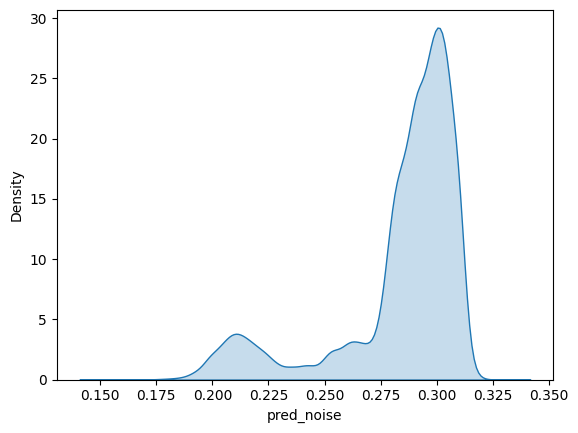

In [18]:
import seaborn as sns

response_mesh_grid["pred_noise"] = response_mesh_grid["pred_noise"] / scaling_factor
sns.kdeplot(response_mesh_grid["pred_noise"], fill=True)

In [ ]:
plotter = MeshGridSlicePlotter.MeshGridSlicePlotter(
    response_mesh_grid,
    parameters,
    "pred_noise",
    optimum_coords,
    cutoff=50,
    empirical_grid_df=unique_combinations,
)
fig = plotter.plot_all_slices()
fig.update_layout(
    title_text="Extrapolated Limonene (mg/L) production noise (std) surface from 83 unique combinations of 4 inducers concentrations".title(),
    title_font_size=20,
)

file_write(fig, "dry-noise")

In [ ]:
empirical_helper.evaluate_model(noise_pipeline, X_noise, y_noise)

Mean Squared Error (MSE) of predicted vs actual: 0.0033
For a total of 81 data points, so RMSE is 0.05730916445289186
Which is 14.53% of the range of y values


c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.11\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning:

X has feature names, but Normalizer was fitted without feature names



0.003284340330288604

In [ ]:
response_mesh_grid[["pred_noise", "pred_response"]].corr()

,pred_noise,pred_response
pred_noise,1.000000,0.698435
pred_response,0.698435,1.000000


* Low association - indicates heteroscedastic noise.

# Running BO on the experimental data

Since BO does not support values lower than 0, our signal and noise are described as:

In [ ]:
def test_function(**kwargs):
    """Passes parameters to the signal model and returns the predicted response."""
    X = np.array([[kwargs[p] for p in parameters]])
    resp = signal_pipeline.predict(X)[0]
    return resp


def noise_function(x, y):
    """Adds noise to a clean response based on the noise model."""
    X = np.array([[x[p] for p in parameters]])
    noise_std = max(0.001, noise_pipeline.predict(X)[0])
    noise = float(y + np.random.normal(0, noise_std))
    return noise

We then construct our experimental policy and run BO search:

In [ ]:
range_parameters = [
    RangeParameterConfig(name=param, parameter_type="float", bounds=bounds)
    for param, bounds in param_bounds.items()
]
tester = ax_helper.SequentialRuns(
    test_function, range_parameters, parameters, "pred_response"
)

In [ ]:
from copy import copy

if False:
    run_dict = {}
    for i in range(20):

        runs = copy(tester).run(
            MaternKernelSGP,
            n_runs=int(568 / 6 / 6),
            technical_repeats=6,
            batch_size=6,
            noise_fn=noise_function,
            plot_each=True,
        )
        obs = runs.get_batch_observations()
        run_dict[i] = obs
    print(i)

    import pickle

    with open("data/mevalonate_pathway/run_dict_better surface.pkl", "wb") as f:
        pickle.dump(run_dict, f)

else:
    with open("data/mevalonate_pathway/run_dict_better", 'rb') as file:
        run_dict = pickle.load(file)

SyntaxError: expected ':' (3773859417.py, line 25)

In [ ]:
distance = []
when = []
for i, obs in run_dict.items():

    norm_dist = empirical_helper.norm_eucl_dist_to_best(
        obs, best_empirical_obs, param_bounds
    )

    min_idx = norm_dist["dist_to_best_empirical"].idxmin()
    best_dist = norm_dist.loc[min_idx, "dist_to_best_empirical"]
    best_trial_index = norm_dist.loc[min_idx, "trial_index"]
    # print(f"Best distance to empirical: {best_dist}, trial index: {best_trial_index}")
    distance.append(best_dist)
    when.append(best_trial_index)

print(np.mean(distance))
print(np.mean(when) / 6)

0.20662536195801637
18.516666666666666


The points investigated by the MaternKernel algorithm, given our SVM interpolated surface and noise were:

In [ ]:
if False:
    from textwrap import fill

    title = """Bayesian Optimisation history with 6 sequential batches of 6 unique points investigated, 6 technical
        repeats each. Current dim value marks the empirically discovered optimum.""".title()
    wrapped_title = "<b>" + fill(title, width=100).replace("\n", "<br>") + "</b>"

    coords = best_empirical_obs.index.values[0]
    fig = runs.plot_GP(MaternKernelSGP, coords, figsize=(12, 6))
    fig.update_layout(
        title_text=wrapped_title,
        title_font_size=16,
        margin=dict(l=20, r=20, t=100, b=40),
        title_y=0.93,
        title_x=0.5,
        title_xanchor="center",
        width=1000,
        height=600,
    )

    file_write(fig, "bayes_empirical")

<Axes: xlabel='group', ylabel='pred_response'>

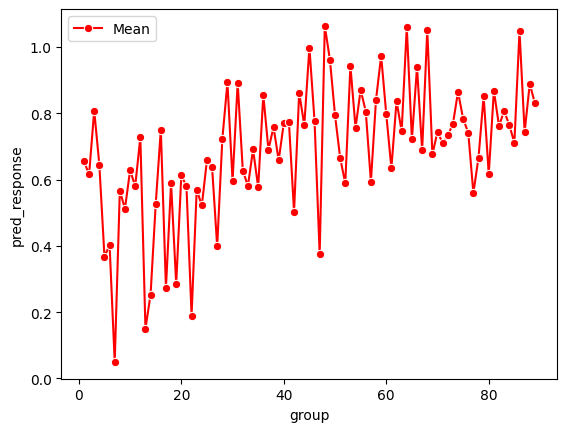

In [ ]:
obs = runs.get_grouped_obs()
# Plot boxplot of predicted response by group
fig = px.box(
    obs, x="group", y="pred_response", points=None, title="Predicted Response by Group"
)
fig.show()

# Plot lineplot of group means
group_means = obs.groupby("group")["pred_response"].mean().reset_index()
sns.lineplot(
    data=group_means,
    x="group",
    y="pred_response",
    marker="o",
    color="red",
    label="Mean",
)

We use Euclidian distance as a proxy for 

<Axes: xlabel='group', ylabel='dist_to_best_empirical'>

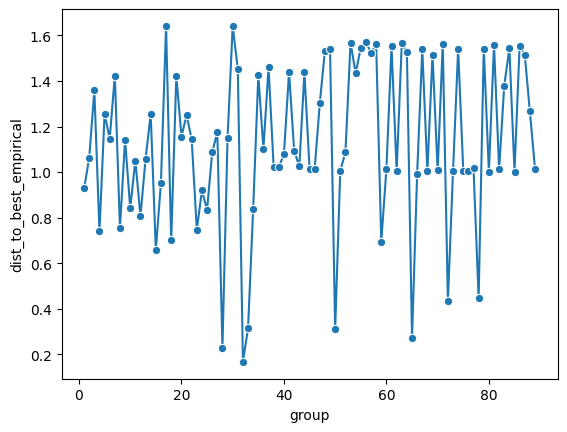

In [ ]:
result_df = runs.get_group_stats()
norm_dist = empirical_helper.norm_eucl_dist_to_best(
    result_df, best_empirical_obs, param_bounds
)
sns.lineplot(data=norm_dist, x="group", y="dist_to_best_empirical", marker="o")

In [ ]:
def add_actual_svm_points(df, svm_model, parameters, response_col="actual_response"):
    """Add actual response values from the SVM model to the DataFrame."""
    X = df[parameters].to_numpy()
    df[response_col] = svm_model.predict(X)
    return df


result_df = add_actual_svm_points(result_df, signal_pipeline, parameters)
result_df.sort_values("dist_to_best_empirical", ascending=True).head(10)

,Ara,Cho,Cuma,IPTG,pred_response,pred_response_var,dist_to_best_empirical,actual_response
group,,,,,,,,
32,50.000000,500.000000,2.000000,200.000000,0.626934,0.271905,0.166667,0.679273
28,50.000000,430.167774,2.000000,200.000000,0.721521,0.310282,0.227727,0.683568
65,50.000000,500.000000,9.851000,200.000000,0.721599,0.226996,0.269500,0.711953
50,50.000000,500.000000,10.582249,200.000000,0.793686,0.186544,0.310125,0.704728
33,50.000000,379.943468,2.000000,200.000000,0.580531,0.300221,0.314573,0.624311
72,31.752972,500.000000,8.764000,200.000000,0.733019,0.302001,0.433865,0.738606
78,30.859820,491.697310,8.443644,190.794050,0.666179,0.239746,0.445773,0.739251
15,50.000000,332.980955,9.838439,117.582158,0.525038,0.191810,0.657124,0.574565
59,17.535143,495.747146,7.810996,196.927271,0.973064,0.257676,0.694433,0.796703


| Ara   | Cho   | Cuma | IPTG | Limonene (mg/L) | Normalization | Average   | Error    | Average.1  | Normalized Average |
|-------|-------|------|------|-----------------|---------------|-----------|----------|------------|--------------------|
| 50.0  | 500.0 | 5.0  | 200  | 56.621526       | 0.814477      | 0.816283  | 0.20091  | 56.621526  | 0.814477           |


# Reanalysing run information:

In [13]:
import pandas as pd
import pickle

pd.set_option("display.width", 200)
pd.set_option("display.max_columns", 20)

In [14]:


with open("data/mevalonate_pathway/run_dict_better.pkl", "rb") as f:
    raw_data = pickle.load(f)

sample_run: pd.DataFrame = raw_data[0]


sample_run.head()

,trial_name,Ara,Cho,Cuma,IPTG,pred_response,trial_index
0,0_0,26.000000,275.000000,11.000000,112.500000,0.762995,0
1,1_0,4.922069,155.353878,13.948891,150.803937,0.585390,1
2,2_0,33.989927,298.712829,6.354747,68.131800,1.032088,2
3,3_0,47.408672,217.447029,18.288189,162.009054,0.761847,3
4,4_0,18.339261,460.999145,10.136694,79.336908,0.507522,4


In [ ]:
def add_true_response(run):
    """Add responses that would be found given no noise"""
    run.loc[:, "true_response"] = run.apply(
        lambda row: signal_pipeline.predict(np.array([[row[p] for p in parameters]]))[0],
        axis=1,
    )
    run = run.dropna()
    run.loc[:, "trial_name"] = run["trial_name"].map(lambda x: int(x.split("_")[0])).astype(int)
    run = run.sort_values(by="trial_name", ascending=True)
    return run

run =add_true_response(sample_run)
run.head()

,trial_name,Ara,Cho,Cuma,IPTG,pred_response,trial_index,true_response
0,0,26.0,275.0,11.0,112.5,0.762995,0,0.56533
9,0,26.0,275.0,11.0,112.5,0.493529,0,0.56533
8,0,26.0,275.0,11.0,112.5,0.484738,0,0.56533
7,0,26.0,275.0,11.0,112.5,0.210991,0,0.56533
6,0,26.0,275.0,11.0,112.5,1.001152,0,0.56533


In [ ]:
run = empirical_helper.norm_eucl_dist_to_best(
    result_df, best_empirical_obs, param_bounds
)

In [39]:
def group_trials(run, scaling_factor, threshold =0.90):
    """get mean of technical repeats. Identify true positives and false positives"""
    grouped = run.groupby(by=parameters + ["trial_name"])[
        ["pred_response", "true_response"]
    ].mean()
    grouped["true_response"] = grouped["true_response"] / scaling_factor
    grouped["pred_response"] = grouped["pred_response"] / scaling_factor

    grouped["diff"] = grouped["pred_response"] - grouped["true_response"]
    grouped.reset_index(inplace=True)
    grouped.sort_values(by="trial_name", inplace=True, ascending=True)
    grouped["trial_name"] = range(len(grouped["trial_name"]))

    grouped["pred_true"] = grouped.pred_response >threshold
    grouped["true_true"] = grouped.true_response >threshold
    grouped["true_positive"] = grouped["pred_true"] & grouped["true_true"]
    grouped["false_positive"] = grouped['pred_true'] & ~grouped["true_true"]

    

    return grouped
grouped = group_trials(run, scaling_factor, threshold = quantiles[0.9])
grouped

,Ara,Cho,Cuma,IPTG,trial_name,pred_response,true_response,diff,pred_true,true_true,true_positive,false_positive
64,26.000000,275.000000,11.000000,112.500000,0,0.704837,0.614419,0.090418,False,False,False,False
58,4.922069,155.353878,13.948891,150.803937,1,0.898760,0.783121,0.115639,True,False,False,True
66,33.989927,298.712829,6.354747,68.131800,2,0.657637,0.672149,-0.014512,False,False,False,False
72,47.408672,217.447029,18.288189,162.009054,3,0.445525,0.586576,-0.141051,False,False,False,False
62,18.339261,460.999145,10.136694,79.336908,4,0.683075,0.783202,-0.100128,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
30,2.000000,254.790317,2.000000,25.000000,71,0.913726,0.835282,0.078445,True,True,True,False
49,2.000000,451.814670,2.000000,200.000000,72,0.797125,0.828775,-0.031651,True,True,True,False
15,2.000000,217.883750,20.000000,25.000000,73,0.828222,0.788741,0.039481,True,False,False,True
46,2.000000,387.963966,2.000000,200.000000,74,0.439394,0.674134,-0.234740,False,False,False,False


,Ara,Cho,Cuma,IPTG,trial_name,pred_response,true_response,diff,pred_true,true_true,true_positive,false_positive,rerun
31,2.000000,469.734512,4.817152,200.000000,84,0.772488,0.852217,-0.079729,False,False,False,False,19
6,2.000000,208.968806,5.627498,25.000000,85,1.139083,0.941492,0.197591,True,True,True,False,19
18,2.000000,266.156953,2.000000,25.000000,86,0.807820,0.834830,-0.027011,False,False,False,False,19
52,4.197021,465.102909,4.829491,55.056121,87,0.965695,0.864309,0.101385,True,False,False,True,19
33,2.000000,474.239426,2.000000,200.000000,88,0.902464,0.846461,0.056004,True,False,False,True,19


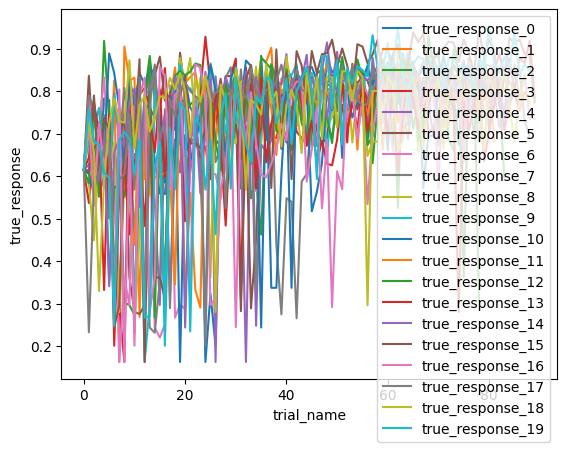

In [40]:
run_dict = {}
run_df =pd.DataFrame()

for i, obs in raw_data.items():
    run = add_true_response(obs)
    group = group_trials(run, scaling_factor)

    run_dict[i]=group
    group['rerun'] = i
    run_df = pd.concat([run_df, group])

    sns.lineplot(y="true_response", x="trial_name", data=group, label = f'true_response_{i}')


run_df.tail()

In [ ]:
x

In [41]:



def prepare_y_array(df:pd.DataFrame) -> np.ndarray:
    df = df.pivot(columns = "rerun", index = 'trial_name', values='true_response')
    matrix = np.array(df)
    return matrix

y_matrix = prepare_y_array(run_df)
y_matrix.shape

(90, 20)

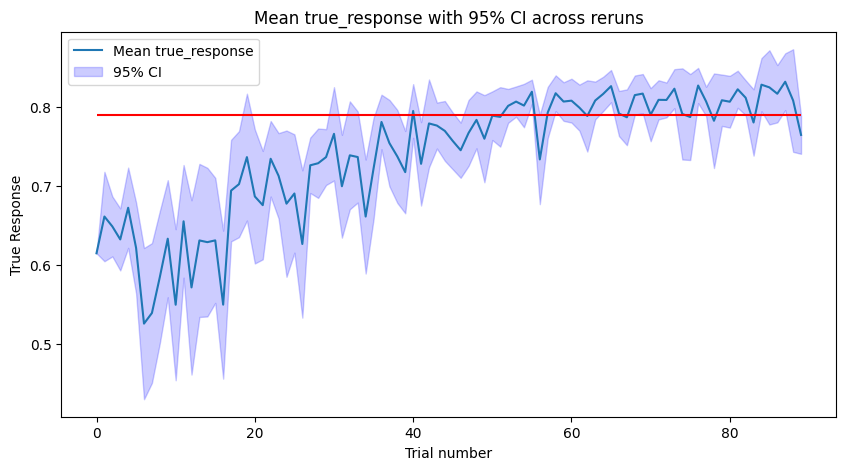

In [44]:
def plot_ci_95(y_matrix:np.ndarray|pd.DataFrame, quantile_val =0.9):
    if isinstance(y_matrix, pd.DataFrame):

        y_matrix:np.ndarray = prepare_y_array(y_matrix)
    
    y_matrix = y_matrix.T
    mean = np.nanmean(y_matrix, axis=0)
    std = np.nanstd(y_matrix, axis=0)
    n = np.sum(~np.isnan(y_matrix), axis=0)
    ci95 = 1.96 * std / np.sqrt(n)

    x = np.arange(len(mean))

    plt.figure(figsize=(10,5))
    plt.plot(x, mean, label='Mean true_response')
    plt.fill_between(x, mean - ci95, mean + ci95, color='b', alpha=0.2, label='95% CI')
    plt.xlabel('Trial number')
    plt.ylabel('True Response')
    plt.title('Mean true_response with 95% CI across reruns')
    plt.legend()
    plt.hlines(y=quantiles[quantile_val], xmin=x.min(), xmax=x.max(), color='r', label ="threshold")

    return mean

mean_values = plot_ci_95(y_matrix, quantile_val =0.9)
plt.show()